##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image segmentation

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/segmentation">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/segmentation.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/segmentation.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/segmentation.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial focuses on the task of image segmentation, using a modified <a href="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/" class="external">U-Net</a>.

## What is image segmentation?
So far you have seen image classification, where the task of the network is to assign a label or class to an input image. However, suppose you want to know where an object is located in the image, the shape of that object, which pixel belongs to which object, etc. In this case you will want to segment the image, i.e., each pixel of the image is given a label. Thus, the task of image segmentation is to train a neural network to output a pixel-wise mask of the image. This helps in understanding the image at a much lower level, i.e., the pixel level. Image segmentation has many applications in medical imaging, self-driving cars and satellite imaging to name a few.

The dataset that will be used for this tutorial is the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/), created by Parkhi *et al*. The dataset consists of images, their corresponding labels, and pixel-wise masks. The masks are basically labels for each pixel. Each pixel is given one of three categories :

*   Class 1 : Pixel belonging to the pet.
*   Class 2 : Pixel bordering the pet.
*   Class 3 : None of the above/ Surrounding pixel.

In [2]:
!pip install git+https://github.com/tensorflow/examples.git
!pip install -U tfds-nightly

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-mxj_kuzc
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-mxj_kuzc
  Created wheel for tensorflow-examples: filename=tensorflow_examples-7f954b871d947d1835d8aa9048ee7ed78340c236_-cp36-none-any.whl size=137064 sha256=90bcc0ee8cd3959af89e329e262a28e4c0ce212fa8d2dd7b7823ca2b73d2cedf
  Stored in directory: /tmp/pip-ephem-wheel-cache-5v3075uj/wheels/83/64/b3/4cfa02dc6f9d16bf7257892c6a7ec602cd7e0ff6ec4d7d714d
Successfully built tensorflow-examples
     |████████████████████████████████| 3.5MB 3.8MB/s 


In [3]:
import tensorflow as tf

In [4]:
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds

from IPython.display import clear_output
import matplotlib.pyplot as plt

## Download the Oxford-IIIT Pets dataset

The dataset is already included in TensorFlow datasets, all that is needed to do is download it. The segmentation masks are included in version 3+.

In [5]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteFZB4TA/oxford_iiit_pet-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteFZB4TA/oxford_iiit_pet-test.tfrecord


Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


The following code performs a simple augmentation of flipping an image. In addition,  image is normalized to [0,1]. Finally, as mentioned above the pixels in the segmentation mask are labeled either {1, 2, 3}. For the sake of convenience, let's subtract 1 from the segmentation mask, resulting in labels that are : {0, 1, 2}.

In [6]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [7]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [8]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

The dataset already contains the required splits of test and train and so let's continue to use the same split.

In [9]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [10]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [11]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

Let's take a look at an image example and it's correponding mask from the dataset.

In [12]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

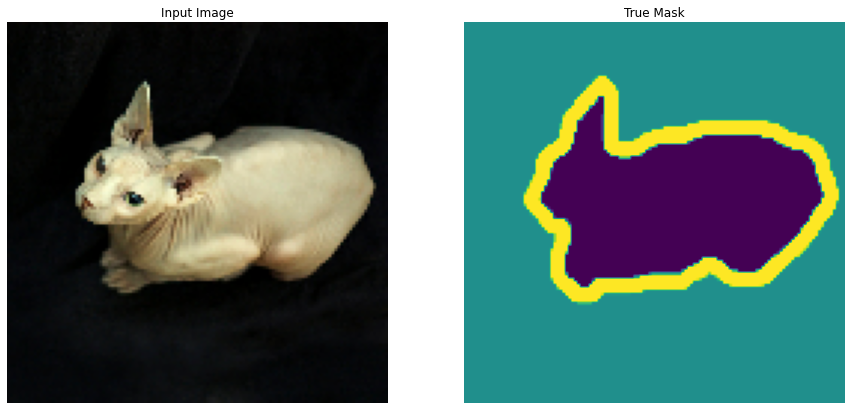

In [14]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

## Define the model
The model being used here is a modified U-Net. A U-Net consists of an encoder (downsampler) and decoder (upsampler). In-order to learn robust features, and reduce the number of trainable parameters, a pretrained model can be used as the encoder. Thus, the encoder for this task will be a pretrained MobileNetV2 model, whose intermediate outputs will be used, and the decoder will be the upsample block already implemented in TensorFlow Examples in the [Pix2pix tutorial](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py). 

The reason to output three channels is because there are three possible labels for each pixel. Think of this as multi-classification where each pixel is being classified into three classes.

In [15]:
OUTPUT_CHANNELS = 3

As mentioned, the encoder will be a pretrained MobileNetV2 model which is prepared and ready to use in [tf.keras.applications](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/applications). The encoder consists of specific outputs from intermediate layers in the model. Note that the encoder will not be trained during the training process.

In [16]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


The decoder/upsampler is simply a series of upsample blocks implemented in TensorFlow examples.

In [17]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [18]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

## Train the model
Now, all that is left to do is to compile and train the model. The loss being used here is `losses.SparseCategoricalCrossentropy(from_logits=True)`. The reason to use this loss function is because the network is trying to assign each pixel a label, just like multi-class prediction. In the true segmentation mask, each pixel has either a {0,1,2}. The network here is outputting three channels. Essentially, each channel is trying to learn to predict a class, and `losses.SparseCategoricalCrossentropy(from_logits=True)` is the recommended loss for 
such a scenario. Using the output of the network, the label assigned to the pixel is the channel with the highest value. This is what the create_mask function is doing.

In [19]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Have a quick look at the resulting model architecture:

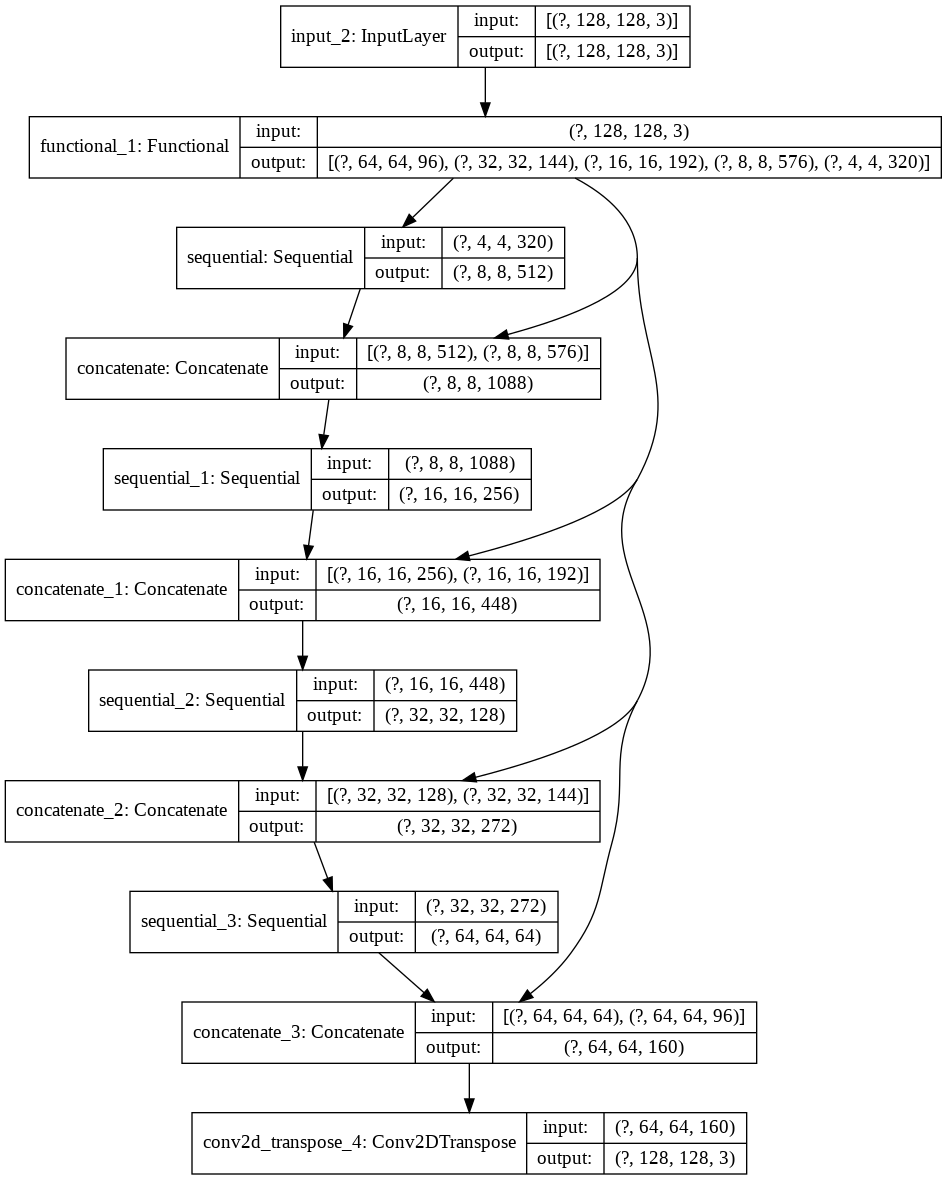

In [20]:
tf.keras.utils.plot_model(model, show_shapes=True)

Let's try out the model to see what it predicts before training.

In [21]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [22]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

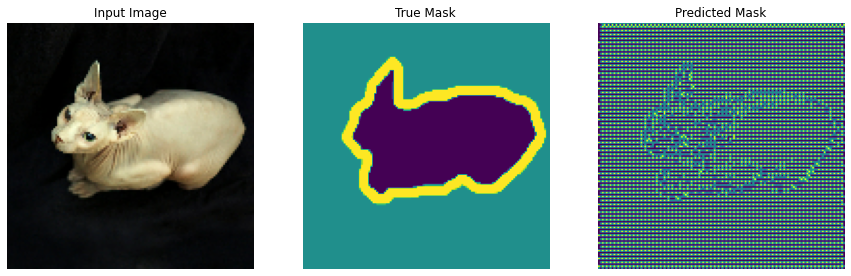

In [23]:
show_predictions()

Let's observe how the model improves while it is training. To accomplish this task, a callback function is defined below. 

In [24]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

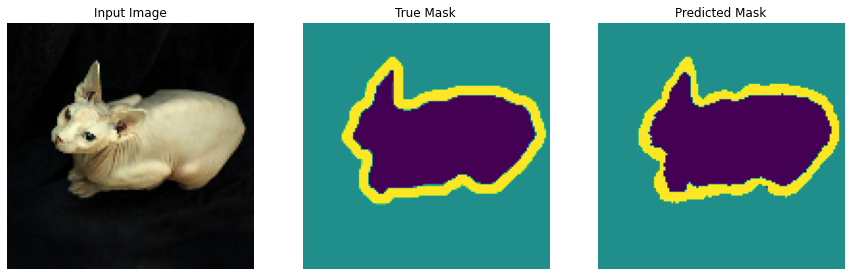


Sample Prediction after epoch 20

57/57 [==============================] - 9s 152ms/step - loss: 0.1345 - accuracy: 0.9385 - val_loss: 0.3202 - val_accuracy: 0.8913


In [25]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

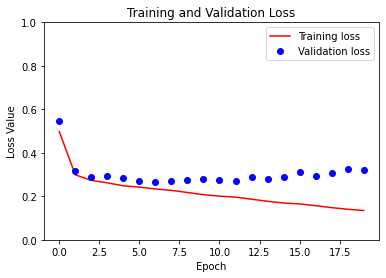

In [26]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## Make predictions

Let's make some predictions. In the interest of saving time, the number of epochs was kept small, but you may set this higher to achieve more accurate results.

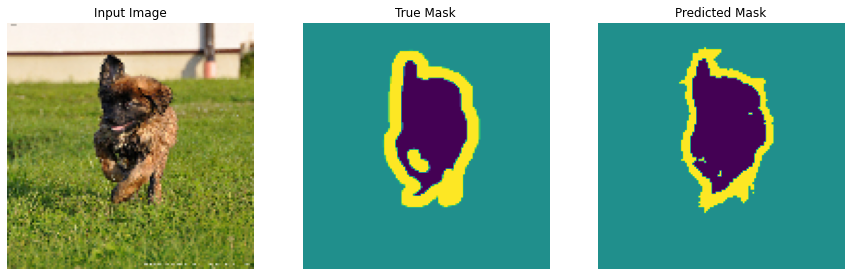

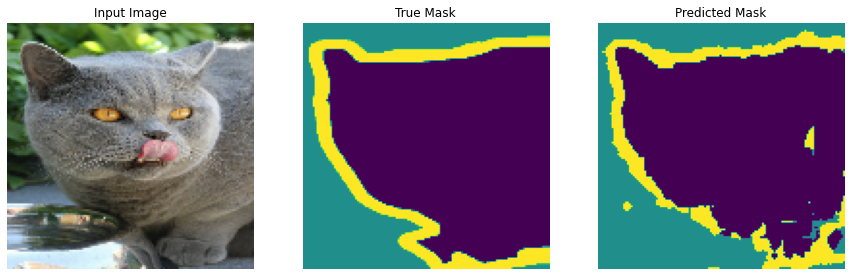

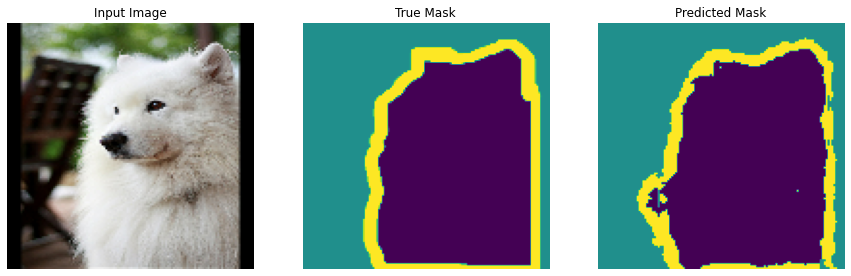

In [28]:
show_predictions(test_dataset, 3)

## Next steps
Now that you have an understanding of what image segmentation is and how it works, you can try this tutorial out with different intermediate layer outputs, or even different pretrained model. You may also challenge yourself by trying out the [Carvana](https://www.kaggle.com/c/carvana-image-masking-challenge/overview) image masking challenge hosted on Kaggle.

You may also want to see the [Tensorflow Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection) for another model you can retrain on your own data.